<table width=100%><tr>
 <td width=170px> <img src="../images/logo.png" alt="Oxford Logo" height="160" width="160"></td>
 <td style="font-size: 35px; text-align:left"> 
 <table>
  <tr><td style="font-size: 30px; text-align:left"> Mining Digital Identity Insights: <br>Patent Analysis using NLP</td></tr>

  </table>   
 </td>
 <td width=200>
 <table>
 <tr><td>  Matthew Comb (2910648)</td></tr>
  <tr><td>matthew.comb@linacre.ox.ac.uk</td></tr>
  </table>
  </td></tr>
</table>

<table width=100%>
<tr>
<td style="font-size: 15px; text-align:left"> | 1. Patent Analysis Summary</td>
</tr>
</table>

  

# Abstract <a class="anchor" id="research-abstract"></a>

The field of digital identity innovation has grown significantly over the last 30 years, with over 6,000 technology patents registered worldwide. However, many questions remain about who controls and owns our digital identity and intellectual property and, ultimately, where the future of digital identity is heading.

To investigate this further, this research mines digital identity patents and explores core themes such as identity, systems, privacy, security, and emerging fields like blockchain, financial transactions, and biometric technologies. Utilizing natural language processing (NLP) methods, including part-of-speech tagging, clustering, topic classification, noise reduction, and lemmatisation techniques. Finally, the research employs graph modelling and statistical analysis to discern inherent trends and forecast future developments.

The findings significantly contribute to the digital identity landscape, identifying key players, emerging trends, and technological progress. This research serves as a valuable resource for academia and industry stakeholders, aiding in strategic decision-making and investment in emerging technologies and facilitating navigation through the dynamic realm of digital identity technologies.

# Table of Contents:

* [Abstract](#research-abstract)
* [Introduction](#research-intro)
* [Research Questions](#research-questions)
* [Data Collection](#research-data)


# Introduction <a class="anchor" id="research-intro"></a>

 This Jupyter notebook is designed to provide an analysis of the filing entities, filing years, and associated metadata of digital identity patents, focusing strictly on the descriptive aspects without examining the patents' content. The aim is to offer insights into the patterns of patent filings, including who is filing patents, when these patents are being filed, and any notable trends in the metadata that might indicate shifts or developments in the field of digital identity.

# Research Questions <a class="anchor" id="research-questions"></a>

1. Who owns the patents behind present day digital identity technology ?
2. Who is most active in the domain ?
3. Are there any noticeable trends present in the patent dataset ?


# Data Collection <a class="anchor" id="research-data"></a>

1. Source: This repository contains a version of the patent database which can be refreshed by downloading from: <br> https://patents.google.com/?q=("digital+identity")&oq="digital+identity"
2. Criteria: the combined term "digital identity" is used as the primary search term. This term must be encases in quotations to ensure "digital" patents are not included. Expected data set is somewhere around 6000+ patents after downloaded n.b. search returns more matches due to variants in files submitted to the registrar. Check the row count in the csv file.
3. Data Format: The file is downloaded in CSV format which is compatible with the remainder of this notebook

## Initialization <a class="anchor" id="nba-discussion-Initialization"></a>

In [145]:
# import python data analysis library
import pandas as pd

# Initialize Pandas - may not be necessary
# pd.set_option('max_columns', 120)
# pd.set_option('max_rows', 20)

In [146]:
# import scientific platform package
import numpy as np

In [147]:
from bs4 import BeautifulSoup

In [148]:
# import plotting libraries
import matplotlib.pyplot as plt
import seaborn as sns
from pylab import rcParams

# import scientific modelling library
from sklearn import linear_model

# set initial configuration values
rcParams['figure.dpi'] = 350
rcParams['lines.linewidth'] = 2
rcParams['axes.facecolor'] = 'white'
rcParams['patch.edgecolor'] = 'white'
rcParams['font.family'] = 'StixGeneral'
rcParams["figure.figsize"] = (13, 3)

# enable plots to be embedded within the notebook
%matplotlib inline

## Data Loading<a class="anchor" id="nba-clean-data"></a>

In [165]:
# Load Patent dataset
wd = pd.read_csv("../Data/Google/digital-identity-full.csv")
# wd = pd.read_csv("../Data/Google/digital-identity-patents-2020.csv")
wd.shape

(6167, 10)

In [167]:
wd.head(2)

,id,title,assignee,inventor/author,priority date,filing/creation date,publication date,grant date,result link,representative figure link
0,US-2018176017-A1,Digital Identity System,Yoti Ltd,"Francisco Angel Garcia RODRIGUEZ, Piers Powles...",2015-02-13,2016-02-12,2018-06-21,NaN,https://patents.google.com/patent/US2018017601...,https://patentimages.storage.googleapis.com/4e...
1,WO-2020191928-A1,"Digital identity authentication method, device...",深圳市网心科技有限公司,张骁,2019-03-27,2019-06-19,2020-10-01,NaN,https://patents.google.com/patent/WO2020191928...,https://patentimages.storage.googleapis.com/6c...


In [168]:
# Clean data into English
wd["assignee"].replace({"한국전자통신연구원": "Electronics and Telecommunications Research Institute"}, inplace=True)
wd["assignee"].replace({"华为技术有限公司": "Huawei"}, inplace=True)
wd["assignee"].replace({"珠海优特电力科技股份有限公司": "Zhuhai Untech Power Technology Co.,Ltd."}, inplace=True)
wd["assignee"].replace({"深圳市元征科技股份有限公司": "Launch Tech"}, inplace=True)
wd["assignee"].replace({"阿里巴巴集团控股有限公司": "Alibaba"}, inplace=True)
wd["assignee"].replace({"北京飞天诚信科技有限公司": "Beijing Feitian Chengxin Technology Co.,Ltd."}, inplace=True)
wd["assignee"].replace({"中兴通讯股份有限公司": "ZTE"}, inplace=True)
wd["assignee"].replace({"湖南大学": "Hunan University"}, inplace=True)
wd["assignee"].replace({"重庆邮电大学": "Chongqing University of Posts and Telecommunications"}, inplace=True)
wd["assignee"].replace({"广东工业大学	": "Guangdong University of Technology"}, inplace=True)
wd["assignee"].replace({"中国联合网络通信集团有限公司": "China Unicom"}, inplace=True)
wd["assignee"].replace({"中国美术学院": "China Academy of Art"}, inplace=True)
wd["assignee"].replace({"Дайболд, Инкорпорейтед": "Diebold, Incorporated"}, inplace=True)
wd["assignee"].replace({"李玉彬": "Li Yubin"}, inplace=True)
wd["assignee"].replace({"微软公司": "Microsoft Corporation"}, inplace=True)
wd["assignee"].replace({"Bundesdruckerei GmbH": "Bundesdruckerei Gmbh"}, inplace=True)
wd["assignee"].replace({"Alibaba": "Alibaba/Alipay"}, inplace=True)
wd["assignee"].replace({"支付宝(杭州)信息技术有限公司": "Alibaba/Alipay"}, inplace=True)
wd["assignee"].replace({"Alibaba Group Holding Limited": "Alibaba/Alipay"}, inplace=True)
wd["assignee"].replace({"Alipay (Hangzhou) Information Technology Corporation": "Alibaba/Alipay"}, inplace=True)
wd["assignee"].replace({"镇江精英软件科技有限公司": "Zenjiang Elite"}, inplace=True)
wd["assignee"].replace({"北京兆信信息技术股份有限公司": "PanPass"}, inplace=True)
wd["assignee"].replace({"北京神秘谷数字科技有限公司": "Mystic Valley"}, inplace=True)
wd["assignee"].replace({"王彦成": "Wang Yancheng"}, inplace=True)
wd["assignee"].replace({"郑州信大捷安信息技术股份有限公司": "Zhengzhou"}, inplace=True)
wd["assignee"].replace({"腾讯科技（深圳）有限公司": "Tencent Tech"}, inplace=True)
wd["assignee"].replace({"中链科技有限公司": "Sinochain"}, inplace=True)
wd["assignee"].replace({"中国工商银行股份有限公司": "Industrial and Commercial Bank of China Limited"}, inplace=True)
wd["assignee"].replace({"蚂蚁区块链科技(上海)有限公司": "Ant Blockchain Technology (Shanghai) Co., Ltd"}, inplace=True)
wd["assignee"].replace({"卓望数码技术（深圳）有限公司": "Aspire Digital Technology (Shenzhen) Co., Ltd"}, inplace=True)

wd.head(5)

,id,title,assignee,inventor/author,priority date,filing/creation date,publication date,grant date,result link,representative figure link
0,US-2018176017-A1,Digital Identity System,Yoti Ltd,"Francisco Angel Garcia RODRIGUEZ, Piers Powles...",2015-02-13,2016-02-12,2018-06-21,NaN,https://patents.google.com/patent/US2018017601...,https://patentimages.storage.googleapis.com/4e...
1,WO-2020191928-A1,"Digital identity authentication method, device...",深圳市网心科技有限公司,张骁,2019-03-27,2019-06-19,2020-10-01,NaN,https://patents.google.com/patent/WO2020191928...,https://patentimages.storage.googleapis.com/6c...
2,US-9785764-B2,Digital identity,Yoti Ltd,"Eleanor Simone Frederika LOUGHLIN-MCHUGH, Roma...",2015-02-13,2015-02-13,2017-10-10,2017-10-10,https://patents.google.com/patent/US9785764B2/en,https://patentimages.storage.googleapis.com/08...
3,US-9858408-B2,Digital identity system,Yoti Holding Limited,"Eleanor Simone Frederika LOUGHLIN-MCHUGH, Roma...",2015-02-13,2015-02-13,2018-01-02,2018-01-02,https://patents.google.com/patent/US9858408B2/en,https://patentimages.storage.googleapis.com/78...
4,EP-3968194-A1,Digital identity,Yoti Holding Limited,"Eleanor Simone Frederika LOUGHLIN-MCHUGH, Rome...",2015-02-13,2016-02-12,2022-03-16,NaN,https://patents.google.com/patent/EP3968194A1/en,https://patentimages.storage.googleapis.com/a2...


In [169]:
wd.head(5)

,id,title,assignee,inventor/author,priority date,filing/creation date,publication date,grant date,result link,representative figure link
0,US-2018176017-A1,Digital Identity System,Yoti Ltd,"Francisco Angel Garcia RODRIGUEZ, Piers Powles...",2015-02-13,2016-02-12,2018-06-21,NaN,https://patents.google.com/patent/US2018017601...,https://patentimages.storage.googleapis.com/4e...
1,WO-2020191928-A1,"Digital identity authentication method, device...",深圳市网心科技有限公司,张骁,2019-03-27,2019-06-19,2020-10-01,NaN,https://patents.google.com/patent/WO2020191928...,https://patentimages.storage.googleapis.com/6c...
2,US-9785764-B2,Digital identity,Yoti Ltd,"Eleanor Simone Frederika LOUGHLIN-MCHUGH, Roma...",2015-02-13,2015-02-13,2017-10-10,2017-10-10,https://patents.google.com/patent/US9785764B2/en,https://patentimages.storage.googleapis.com/08...
3,US-9858408-B2,Digital identity system,Yoti Holding Limited,"Eleanor Simone Frederika LOUGHLIN-MCHUGH, Roma...",2015-02-13,2015-02-13,2018-01-02,2018-01-02,https://patents.google.com/patent/US9858408B2/en,https://patentimages.storage.googleapis.com/78...
4,EP-3968194-A1,Digital identity,Yoti Holding Limited,"Eleanor Simone Frederika LOUGHLIN-MCHUGH, Rome...",2015-02-13,2016-02-12,2022-03-16,NaN,https://patents.google.com/patent/EP3968194A1/en,https://patentimages.storage.googleapis.com/a2...


In [170]:
# Rename Columns to be consistent
wd = wd.rename(columns={'id': 'ID'})
wd = wd.rename(columns={'title': 'Title'})
wd = wd.rename(columns={'assignee': 'Assignee'})
wd = wd.rename(columns={'inventor/author': 'Inventor'})
wd = wd.rename(columns={'priority date': 'PriorityDate'})
wd = wd.rename(columns={'filing/creation date': 'CreationDate'})
wd = wd.rename(columns={'publication date': 'PublicationDate'})
wd = wd.rename(columns={'grant date': 'GrantDate'})
wd = wd.rename(columns={'result link': 'Result'})
wd = wd.rename(columns={'representative figure link': 'Figure'})

In [171]:
wd.dropna(subset = ['CreationDate'], inplace=True)
wd.shape

(6164, 10)

In [172]:
wdfull = wd
wd = wd.drop(['Result', 'Figure'], axis=1)

# Output small sample to check format
wd.head(5)

,ID,Title,Assignee,Inventor,PriorityDate,CreationDate,PublicationDate,GrantDate
0,US-2018176017-A1,Digital Identity System,Yoti Ltd,"Francisco Angel Garcia RODRIGUEZ, Piers Powles...",2015-02-13,2016-02-12,2018-06-21,NaN
1,WO-2020191928-A1,"Digital identity authentication method, device...",深圳市网心科技有限公司,张骁,2019-03-27,2019-06-19,2020-10-01,NaN
2,US-9785764-B2,Digital identity,Yoti Ltd,"Eleanor Simone Frederika LOUGHLIN-MCHUGH, Roma...",2015-02-13,2015-02-13,2017-10-10,2017-10-10
3,US-9858408-B2,Digital identity system,Yoti Holding Limited,"Eleanor Simone Frederika LOUGHLIN-MCHUGH, Roma...",2015-02-13,2015-02-13,2018-01-02,2018-01-02
4,EP-3968194-A1,Digital identity,Yoti Holding Limited,"Eleanor Simone Frederika LOUGHLIN-MCHUGH, Rome...",2015-02-13,2016-02-12,2022-03-16,NaN


In [173]:
# Helper function to analyse NaN values
def missing_values_table(df): 
        mis_val = df.isnull().sum()
        mis_val_percent = 100 * df.isnull().sum()/len(df)
        mis_val_table = pd.concat([mis_val, mis_val_percent], axis=1)
        mis_val_table_ren_columns = mis_val_table.rename(
        columns = {0 : 'Missing Values', 1 : '% of Total Values'})
        return mis_val_table_ren_columns 

In [174]:
wd["CreationDate"]= pd.to_datetime(wd["CreationDate"])
wd = wd[wd['CreationDate'].dt.year >= 1996]
wd = wd[wd['CreationDate'].dt.year <= 2020]
wd.shape

(4054, 8)

In [175]:
wd['Year'] = pd.to_datetime(wd['CreationDate']).dt.to_period('Y').astype(str)
wdfull['Year'] = pd.to_datetime(wdfull['CreationDate']).dt.to_period('Y').astype(str)
display(wd.head())

# Establish Yearly dataframe
wdYear = wd.groupby(['Year'], as_index=False)[["ID","Assignee"]].count()

# Output statistics by year.
# wdYear.describe()

,ID,Title,Assignee,Inventor,PriorityDate,CreationDate,PublicationDate,GrantDate,Year
0,US-2018176017-A1,Digital Identity System,Yoti Ltd,"Francisco Angel Garcia RODRIGUEZ, Piers Powles...",2015-02-13,2016-02-12,2018-06-21,NaN,2016
1,WO-2020191928-A1,"Digital identity authentication method, device...",深圳市网心科技有限公司,张骁,2019-03-27,2019-06-19,2020-10-01,NaN,2019
2,US-9785764-B2,Digital identity,Yoti Ltd,"Eleanor Simone Frederika LOUGHLIN-MCHUGH, Roma...",2015-02-13,2015-02-13,2017-10-10,2017-10-10,2015
3,US-9858408-B2,Digital identity system,Yoti Holding Limited,"Eleanor Simone Frederika LOUGHLIN-MCHUGH, Roma...",2015-02-13,2015-02-13,2018-01-02,2018-01-02,2015
4,EP-3968194-A1,Digital identity,Yoti Holding Limited,"Eleanor Simone Frederika LOUGHLIN-MCHUGH, Rome...",2015-02-13,2016-02-12,2022-03-16,NaN,2016


In [176]:
allTimeContributers = pd.DataFrame(wd['Assignee'].value_counts().reset_index())
allTimeContributers = allTimeContributers.rename(columns = {'Assignee': 'Count', 'index': 'Assignee'}, inplace = False)
allTimeContributers.head(10)

,Count,count
0,Alibaba/Alipay,82
1,Microsoft Corporation,66
2,Bundesdruckerei Gmbh,56
3,Oracle International Corporation,54
4,International Business Machines Corporation,53
5,"Cisco Technology, Inc.",37
6,"Aspire Digital Technology (Shenzhen) Co., Ltd",31
7,Mastercard International Incorporated,31
8,"Diebold, Incorporated",31
9,"Forcepoint, LLC",30


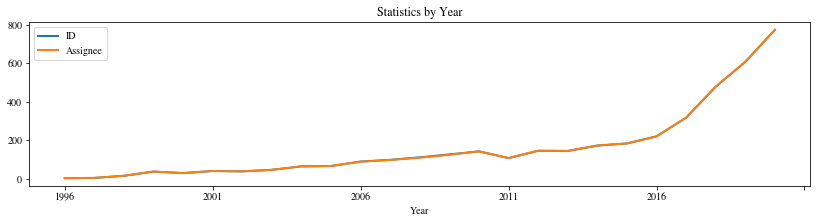

In [177]:
# Index the data
indexed_dfYearly = wdYear.set_index(['Year'])

# Plot Yearly graph to determine any high level anomalies
indexed_dfYearly = wdYear.set_index(['Year']).plot(figsize=(14,3)).set_title('Statistics by Year')

In [45]:
# Helper function to select data per time period
def select_period(df, start_year, end_year, id):
    new = df[(df.Year.astype(int) >= start_year) & (df.Year.astype(int) <= end_year)].copy()
    new['ruleset'] = id
    return new

In [46]:
# Implement helper function for player name lookup
def rank_by_year_and(df):
    x = df[['Assignee','Year']].sort_values( by=[], ascending=False)
    x['Rank']= df[y].count().rank(ascending=False)
    return x

In [47]:
def fill_stat2(df, st, a, i):
    if (a.size > i):
        pd.DataFrame(df).iloc[i][(st,'Assignee')] = a.iloc[i]['Assignee']
        pd.DataFrame(df).iloc[i][(st,'Count')] = a.iloc[i]['Name']
    return df

In [178]:
# Establish the Player dataframe
dfx = wd.groupby(['Year', 'Assignee']).size()
dfx

Year  Assignee               
1996  Джеффри А. Хармен          1
      株式会社リコー                    1
      英国电讯有限公司                   1
1997  Diebold, Incorporated      2
      Domain Dynamics Limited    1
                                ..
2020  인제대학교 산학협력단                1
      주식회사 디젠트아이디                2
      주식회사 디지털존                  1
      케이포시큐리티 주식회사               1
      한신대학교 산학협력단                1
Length: 2806, dtype: int64

In [179]:
# Establish statistics based on period
# Establish the Player dataframe
wd['Name'] = wd['Assignee']
dfE = select_period(wd, 1996, 2000, 'E').groupby(['Assignee'], as_index=False).count().sort_values('Name', ascending=False)
dfF = select_period(wd, 2001, 2005, 'F').groupby(['Assignee'], as_index=False).count().sort_values('Name', ascending=False)
dfG = select_period(wd, 2006, 2010, 'G').groupby(['Assignee'], as_index=False).count().sort_values('Name', ascending=False)
dfH = select_period(wd, 2011, 2015, 'H').groupby(['Assignee'], as_index=False).count().sort_values('Name', ascending=False)
dfI = select_period(wd, 2016, 2020, 'I').groupby(['Assignee'], as_index=False).count().sort_values('Name', ascending=False)

# Define column headers as tuples so the table lays out more effectively.
columns = pd.MultiIndex.from_tuples([
            ('1996-2000', 'Assignee'), ('1996-2000', 'Count'),
            ('2001-2005', 'Assignee'), ('2001-2005', 'Count'),
            ('2006-2010', 'Assignee'), ('2006-2010', 'Count'),
            ('2011-2015', 'Assignee'), ('2011-2015', 'Count'),
            ('2016-2020', 'Assignee'), ('2016-2020', 'Count'),
            ],
            names=['Assignee', 'Count']
            )

# Establish frame for combining all key player statistics
combine = pd.DataFrame(index=range(10), columns=columns)

# Loop and combine top ten list
for i in range(10):
       combine = fill_stat2(combine, '1996-2000', dfE, i)
       combine = fill_stat2(combine, '2001-2005', dfF, i)
       combine = fill_stat2(combine, '2006-2010', dfG, i)
       combine = fill_stat2(combine, '2011-2015', dfH, i)
       combine = fill_stat2(combine, '2016-2020', dfI, i)
combine

# Group the frames
#frames = [dfA, dfB, dfC, dfD, dfE, dfF, dfG, dfH, dfI]
#dfYearlyRules = pd.concat(frames)
#dfYearlyRules

Assignee                                          1996-2000        \
Count                                              Assignee Count   
0                                     Diebold, Incorporated    16   
1               International Business Machines Corporation     7   
2         Diebold, Incorporated, Jay Paul Drummond, Dale...     5   
3                                                  Li Yubin     3   
4                                               Diebold Inc     3   
5         Американ Экспресс Тревл Рилейтед Сервисиз Комп...     2   
6                                 N★Able Technologies, Inc.     1   
7                                   Skylight Software, Inc.     1   
8                                      Secure Accounts Ltd.     1   
9                                          Phasespace, Inc.     1   

Assignee                                          2001-2005        \
Count                                              Assignee Count   
0                                     Microsoft Corporation    13   
1                                     Diebold, Incorporated    12   
2                                                    Huawei     8   
3         Electronics and Telecommunications Research In...     6   
4                                    Sap Aktiengesellschaft     4   
5                                         Solomon Dennis J.     3   
6                                     Toshiba Res Europ Ltd     3   
7               International Business Machines Corporation     3   
8                                   Hewlett Packard Company     2   
9                                          Ntt Docomo, Inc.     2   

Assignee                                          2006-2010        \
Count                                              Assignee Count   
0                                     Microsoft Corporation    43   
1             Aspire Digital Technology (Shenzhen) Co., Ltd    30   
2                                      Bundesdruckerei Gmbh    14   
3                                  The Go Daddy Group, Inc.    14   
4                                            Alcatel Lucent    13   
5              Beijing Feitian Chengxin Technology Co.,Ltd.    12   
6                                                       ZTE     9   
7         Electronics and Telecommunications Research In...     7   
8               International Business Machines Corporation     6   
9                                      Symantec Corporation     6   

Assignee                                2011-2015        \
Count                                    Assignee Count   
0                            Bundesdruckerei Gmbh    17   
1                                    Tyfone, Inc.    15   
2               Verizon Patent And Licensing Inc.    15   
3                          Cisco Technology, Inc.    15   
4         Zhuhai Untech Power Technology Co.,Ltd.    13   
5                           Microsoft Corporation    10   
6                             Flextronics Ap, Llc    10   
7                                      Apple Inc.     9   
8                                         PanPass     8   
9                                  Zenjiang Elite     8   

Assignee                                    2016-2020        
Count                                        Assignee Count  
0                                      Alibaba/Alipay    80  
1                    Oracle International Corporation    52  
2                                     Forcepoint, LLC    30  
3         International Business Machines Corporation    30  
4               Mastercard International Incorporated    29  
5                         Bank Of America Corporation    25  
6                                Bundesdruckerei Gmbh    25  
7                                       Workday, Inc.    23  
8                                        Tencent Tech    22  
9                                         Launch Tech    21

In [79]:
# Establish statistics based on period
# Establish the Player dataframe
wd['Name'] = wd['Assignee']
dfE = select_period(wd, 2016, 2016, 'E').groupby(['Assignee'], as_index=False).count().sort_values('Name', ascending=False)
dfF = select_period(wd, 2017, 2017, 'F').groupby(['Assignee'], as_index=False).count().sort_values('Name', ascending=False)
dfG = select_period(wd, 2018, 2018, 'G').groupby(['Assignee'], as_index=False).count().sort_values('Name', ascending=False)
dfH = select_period(wd, 2019, 2019, 'H').groupby(['Assignee'], as_index=False).count().sort_values('Name', ascending=False)
dfI = select_period(wd, 2020, 2020, 'I').groupby(['Assignee'], as_index=False).count().sort_values('Name', ascending=False)

# Define column headers as tuples so the table lays out more effectively.
columns = pd.MultiIndex.from_tuples([
            ('2016', 'Assignee'), ('2016', 'Count'),
            ('2017', 'Assignee'), ('2017', 'Count'),
            ('2018', 'Assignee'), ('2018', 'Count'),
            ('2019', 'Assignee'), ('2019', 'Count'),
            ('2020', 'Assignee'), ('2020', 'Count'),
            ],
            names=['Assignee', 'Count']
            )

# Establish frame for combining all key player statistics
combine = pd.DataFrame(index=range(10), columns=columns)

# Loop and combine top ten list
for i in range(10):
       combine = fill_stat2(combine, '2016', dfE, i)
       combine = fill_stat2(combine, '2017', dfF, i)
       combine = fill_stat2(combine, '2018', dfG, i)
       combine = fill_stat2(combine, '2019', dfH, i)
       combine = fill_stat2(combine, '2020', dfI, i)
combine

# Group the frames
#frames = [dfA, dfB, dfC, dfD, dfE, dfF, dfG, dfH, dfI]
#dfYearlyRules = pd.concat(frames)
#dfYearlyRules

Assignee                                         2016        \
Count                                        Assignee Count   
0                               Cognitive Scale, Inc.    16   
1                                Bundesdruckerei Gmbh     8   
2         International Business Machines Corporation     5   
3                                       Mystic Valley     4   
4                                       Wang Yancheng     4   
5                                            Yoti Ltd     4   
6                         Bank Of America Corporation     3   
7                 Microsoft Technology Licensing, Llc     3   
8                                            Sal Khan     3   
9                         Sebastien Jean Serge Dupont     3   

Assignee                              2017        \
Count                             Assignee Count   
0         Oracle International Corporation    28   
1                     Bundesdruckerei Gmbh     7   
2                                 Bao Tran     6   
3              Bank Of America Corporation     6   
4                   Cisco Technology, Inc.     5   
5                                Zhengzhou     5   
6                             北京梆梆安全科技有限公司     5   
7                             山东东进航空科技有限公司     4   
8                             北京中广掌视科技有限公司     4   
9                                Sinochain     4   

Assignee                                         2018        \
Count                                        Assignee Count   
0                         Bank Of America Corporation    14   
1                                     Forcepoint, LLC    13   
2                                      Alibaba/Alipay    12   
3         International Business Machines Corporation    11   
4                               Black Gold Coin, Inc.    10   
5                                         Launch Tech     7   
6                    Oracle International Corporation     6   
7                                        Tencent Tech     6   
8               Mastercard International Incorporated     5   
9                                        上海千加信息科技有限公司     5   

Assignee                                    2019        \
Count                                   Assignee Count   
0                                 Alibaba/Alipay    24   
1                                  Workday, Inc.    14   
2                                    Launch Tech    13   
3               Oracle International Corporation     9   
4         Visa International Service Association     8   
5          Mastercard International Incorporated     8   
6                                   China Unicom     7   
7                   Honeywell International Inc.     6   
8                                 Forcepoint Llc     6   
9                                   Tencent Tech     5   

Assignee                                               2020        
Count                                              Assignee Count  
0                                            Alibaba/Alipay    13  
1                                          Hunan University     2  
2         Alipay (Hangzhou) Information Technology Co., ...     2  
3                                              上海东普信息科技有限公司     1  
4                                           恩亿科(北京)数据科技有限公司     1  
5                                                    广东工业大学     1  
6                                          常州唯实智能物联创新中心有限公司     1  
7                                              嵩链(上海)科技有限公司     1  
8                               国网区块链科技(北京)有限公司, 国网电子商务有限公司     1  
9                                                      四川大学     1

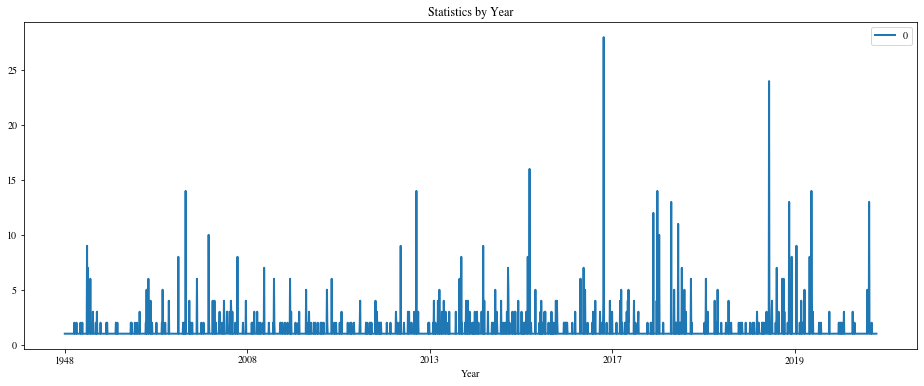

In [80]:
# Index the data
indexed_dfYearly = dfx.reset_index().set_index('Year')

# Plot Yearly graph to determine any high level anomalies
indexed_dfYearly_plot = dfx.reset_index().set_index(['Year']).plot(figsize=(16,6)).set_title('Statistics by Year')

In [223]:
#0	Microsoft Corporation	54
#1	International Business Machines Corporation	46
#2	Oracle International Corporation	46
#3	Diebold, Incorporated	28
#4	Bundesdruckerei Gmbh	28
#5	Bank Of America Corporation	27
#6	Cisco Technology, Inc.	25
#7	阿里巴巴集团控股有限公司	22
#8	Mastercard International Incorporated	21
#9	支付宝(杭州)信息技术有限公司	20
indexed_dfYearly2 = indexed_dfYearly.reset_index().groupby(['Year','Assignee'])
df1 = indexed_dfYearly[(indexed_dfYearly.Assignee == 'Microsoft Corporation')]
df2 = indexed_dfYearly[(indexed_dfYearly.Assignee == 'International Business Machines Corporation')]
df3 = indexed_dfYearly[(indexed_dfYearly.Assignee == 'Oracle International Corporation')]
df4 = indexed_dfYearly[(indexed_dfYearly.Assignee == 'Diebold, Incorporated')]
df5 = indexed_dfYearly[(indexed_dfYearly.Assignee == 'Bundesdruckerei Gmbh')]
df6 = indexed_dfYearly[(indexed_dfYearly.Assignee == 'Bank Of America Corporation')]
df7 = indexed_dfYearly[(indexed_dfYearly.Assignee == 'Cisco Technology, Inc.')]
df8 = indexed_dfYearly[(indexed_dfYearly.Assignee == '阿里巴巴集团控股有限公司')]
df9 = indexed_dfYearly[(indexed_dfYearly.Assignee == 'Mastercard International Incorporated')]
df10 = indexed_dfYearly[(indexed_dfYearly.Assignee == '支付宝(杭州)信息技术有限公司')]
#display(indexed_dfYearly_A.head(10))

frames = [df1, df2, df3, df4, df5, df6, df7, df8, df9, df10]

result = pd.concat(frames)
result = result.rename(columns={'0': 'Count'})
result = pd.pivot_table(result, index=['Year'], columns = 'Assignee')
result = result.fillna(0)
result.columns = result.columns.droplevel()
display(result.head(50))


Assignee,Bank Of America Corporation,Bundesdruckerei Gmbh,"Cisco Technology, Inc.","Diebold, Incorporated",International Business Machines Corporation,Mastercard International Incorporated,Microsoft Corporation,Oracle International Corporation
Year,,,,,,,,
1997,0.0,0.0,0.0,2.0,0.0,0.0,0.0,0.0
1998,0.0,0.0,0.0,2.0,0.0,0.0,0.0,0.0
1999,0.0,0.0,0.0,9.0,6.0,0.0,0.0,0.0
2000,0.0,0.0,0.0,3.0,2.0,0.0,0.0,0.0
2001,0.0,0.0,0.0,1.0,2.0,0.0,0.0,0.0
2002,0.0,0.0,0.0,2.0,0.0,0.0,1.0,0.0
2003,0.0,0.0,0.0,1.0,0.0,0.0,1.0,0.0
2004,0.0,0.0,0.0,2.0,1.0,0.0,4.0,0.0
2005,0.0,0.0,0.0,5.0,0.0,1.0,4.0,1.0


In [143]:
import warnings
warnings.filterwarnings("ignore")
#indexed_dfYearly_A_plot = indexed_dfYearly_A.reset_index().set_index(['Year']).plot(figsize=(14,3)).set_title('Statistics by Year')
result_plot = result.plot(figsize=(16,10)).set_title('Statistics by Year')

NameError: name 'result' is not defined

In [269]:
pd.set_option('display.max_colwidth', -1)
name = 'Cognitive Scale, Inc.'
grp = wdfull[((wdfull.Assignee == name))]
grp = grp.sort_values(by=['CreationDate'])
grp = grp[["ID", "Title", "Result", "Year"]]
"""grp = grp[(grp.Year == '2017')]"""
pd.set_option('display.max_rows', None)
print(grp.shape)

a = grp[(grp.Title.astype(str).str.contains('Blockchain'))]
print(a.shape)
b = grp[(grp.Title.astype(str).str.contains('Graph'))]
print(b.shape)
c = grp[(grp.Title.astype(str).str.contains('chain'))]
print(c.shape)
d = grp[(grp.Title.astype(str).str.contains('payment'))]
print(d.shape)
e = grp[(grp.Title.astype(str).str.contains('authentication'))]
print(e.shape)
grp.head(62)

(16, 4)
(16, 4)
(2, 4)
(16, 4)
(0, 4)
(0, 4)


,ID,Title,Result,Year
445,US-2018129945-A1,Method for Cognitive Information Processing Using a Cognitive Blockchain Architecture,https://patents.google.com/patent/US20180129945A1/en,2016
1207,US-2018129958-A1,Cognitive Session Graphs Including Blockchains,https://patents.google.com/patent/US20180129958A1/en,2016
1215,US-2018129953-A1,System for Performing Compliance Operations Using Cognitive Blockchains,https://patents.google.com/patent/US20180129953A1/en,2016
1216,US-2018129955-A1,Hybrid Blockchain Data Architecture for use Within a Cognitive Environment,https://patents.google.com/patent/US20180129955A1/en,2016
1234,US-2018129956-A1,Method for Using Hybrid Blockchain Data Architecture Within a Cognitive Environment,https://patents.google.com/patent/US20180129956A1/en,2016
1257,US-2018129957-A1,Cognitive Session Graphs Including Blockchains,https://patents.google.com/patent/US20180129957A1/en,2016
1274,US-2018129954-A1,Performing Compliance Operations Using Cognitive Blockchains,https://patents.google.com/patent/US20180129954A1/en,2016
1275,US-2018129952-A1,Cognitive Information Processing Using a Cognitive Blockchain Architecture,https://patents.google.com/patent/US20180129952A1/en,2016
1205,US-2018165585-A1,Method for Providing Procurement Related Cognitive Insights Using Blockchains,https://patents.google.com/patent/US20180165585A1/en,2016
1213,US-2018165586-A1,Providing Procurement Related Cognitive Insights Using Blockchains,https://patents.google.com/patent/US20180165586A1/en,2016


In [48]:
grp.tail(1)

,ID,Title,Assignee,Inventor,CreationDate,Result,Year
856,US-2020076817-A1,Service Discovery for a Multi-Tenant Identity ...,Oracle International Corporation,"Lokesh Gupta, Vadim Lander",2019-11-08,https://patents.google.com/patent/US2020007681...,2019


In [102]:
headers = {
    'Access-Control-Allow-Origin': '*',
    'Access-Control-Allow-Methods': 'GET',
    'Access-Control-Allow-Headers': 'Content-Type',
    'Access-Control-Max-Age': '3600',
    'User-Agent': 'Mozilla/5.0 (X11; Ubuntu; Linux x86_64; rv:52.0) Gecko/20100101 Firefox/52.0'
    }

In [103]:
"""Scrape metadata from target URL."""
import requests
from bs4 import BeautifulSoup
import pprint
import urllib

def get_download_url(url):
    """Scrape target URL for metadata."""
    headers = {
        'Access-Control-Allow-Origin': '*',
        'Access-Control-Allow-Methods': 'GET',
        'Access-Control-Allow-Headers': 'Content-Type',
        'Access-Control-Max-Age': '3600',
        'User-Agent': 'Mozilla/5.0 (X11; Ubuntu; Linux x86_64; rv:52.0) Gecko/20100101 Firefox/52.0'
    }
    
    r = requests.get(url, headers=headers)
    html = BeautifulSoup(r.content, 'html.parser')
    print(html)
    return get_pdf(html)
    
def download_file(url, filename):
    urllib.urlretrieve ("http://www.example.com/songs/mp3.mp3", "mp3.mp3")

def scrape_page_metadata(url):
    """Scrape target URL for metadata."""
    headers = {
        'Access-Control-Allow-Origin': '*',
        'Access-Control-Allow-Methods': 'GET',
        'Access-Control-Allow-Headers': 'Content-Type',
        'Access-Control-Max-Age': '3600',
        'User-Agent': 'Mozilla/5.0 (X11; Ubuntu; Linux x86_64; rv:52.0) Gecko/20100101 Firefox/52.0'
    }
    
    r = requests.get(url, headers=headers)
    html = BeautifulSoup(r.content, 'html.parser')
    metadata = {
        'title': get_title(html),
        'description': get_description(html),
        'pdf': get_pdf(html),
        'image': get_image(html),
        'favicon': get_favicon(html, url),
        'sitename': get_site_name(html, url),
        'color': get_theme_color(html),
        'url': url
        }

    return metadata


def get_title(html):
    """Scrape page title."""
    title = None
    if html.title.string:
        title = html.title.string
    elif html.find("meta", property="og:title"):
        title = html.find("meta", property="og:title").get('content')
    elif html.find("meta", property="twitter:title"):
        title = html.find("meta", property="twitter:title").get('content')
    elif html.find("h1"):
        title = html.find("h1").string
    return title

def get_pdf(html):
    return html.find("meta",  {"name":"citation_pdf_url"}).get('content')

def get_description(html):
    """Scrape page description."""
    description = None
    if html.find("meta", property="description"):
        description = html.find("meta", property="description").get('content')
    elif html.find("meta", property="og:description"):
        description = html.find("meta", property="og:description").get('content')
    elif html.find("meta", property="twitter:description"):
        description = html.find("meta", property="twitter:description").get('content')
    elif html.find("p"):
        description = html.find("p").contents
    return description


def get_image(html):
    """Scrape share image."""
    image = None
    if html.find("meta", property="image"):
        image = html.find("meta", property="image").get('content')
    elif html.find("meta", property="og:image"):
        image = html.find("meta", property="og:image").get('content')
    elif html.find("meta", property="twitter:image"):
        image = html.find("meta", property="twitter:image").get('content')
    elif html.find("img", src=True):
        image = html.find_all("img")[0].get('src')
    return image


def get_site_name(html, url):
    """Scrape site name."""
    if html.find("meta", property="og:site_name"):
        site_name = html.find("meta", property="og:site_name").get('content')
    elif html.find("meta", property='twitter:title'):
        site_name = html.find("meta", property="twitter:title").get('content')
    else:
        site_name = url.split('//')[1]
        return site_name.split('/')[0].rsplit('.')[1].capitalize()
    return sitename


def get_favicon(html, url):
    """Scrape favicon."""
    if html.find("link", attrs={"rel": "icon"}):
        favicon = html.find("link", attrs={"rel": "icon"}).get('href')
    elif html.find("link", attrs={"rel": "shortcut icon"}):
        favicon = html.find("link", attrs={"rel": "shortcut icon"}).get('href')
    else:
        favicon = f'{url.rstrip("/")}/favicon.ico'
    return favicon


def get_theme_color(html):
    """Scrape brand color."""
    if html.find("meta", property="theme-color"):
        color = html.find("meta", property="theme-color").get('content')
        return color
    return None

In [104]:
import requests
import json
import urllib.request
from pathlib import Path
import pdfplumber
from sklearn.feature_extraction.text import CountVectorizer
import re
def pre_process(text):
    
    # lowercase
    text=text.lower()
    
    #remove tags
    text=re.sub("</?.*?>"," <> ",text)
    
    # remove special characters and digits
    text=re.sub("(\\d|\\W)+"," ",text)
    
    return text

def get_stop_words(stop_file_path):
    """load stop words """
    
    with open(stop_file_path, 'r', encoding="utf-8") as f:
        stopwords = f.readlines()
        stop_set = set(m.strip() for m in stopwords)
        return frozenset(stop_set)
    
def sort_coo(coo_matrix):
    tuples = zip(coo_matrix.col, coo_matrix.data)
    return sorted(tuples, key=lambda x: (x[1], x[0]), reverse=True)

def extract_topn_from_vector(feature_names, sorted_items, topn=10):
    """get the feature names and tf-idf score of top n items"""
    
    #use only topn items from vector
    sorted_items = sorted_items[:topn]

    score_vals = []
    feature_vals = []

    for idx, score in sorted_items:
        fname = feature_names[idx]
        
        #keep track of feature name and its corresponding score
        score_vals.append(round(score, 3))
        feature_vals.append(feature_names[idx])

    #create a tuples of feature,score
    #results = zip(feature_vals,score_vals)
    results= {}
    for idx in range(len(feature_vals)):
        results[feature_vals[idx]]=score_vals[idx]
    
    return results

from bs4 import BeautifulSoup
pp = pprint.PrettyPrinter(indent=4)
for index, row in microsoft.iterrows():
    url = row['Result']
    print(url)
    #print(get_download_url(url))
    data = scrape_page_metadata(url)
    
    pdfURL = data["pdf"]
    print(pdfURL)
    
    path = "./PDF/" + row['Assignee']
    Path(path).mkdir(parents=True, exist_ok=True)
    
    path = "./PDF/" + row['Assignee'] + '/' + row['ID'] + ".pdf"
    print(path)
    urllib.request.urlretrieve(pdfURL, path)
    
    pages = list()
    fulltext = "";
    count = 0;
    with pdfplumber.open(path) as pdf:
        for page in pdf.pages:
            text = page.extract_text()
            text = pre_process(text)
            
            pages.append(text)
            count = count +1;
            if count > 15:
                fulltext = fulltext + text;

            #load a set of stop words
        stopwords=get_stop_words("./Files/stopwords.txt")

        #get the text column 
        #docs=df_idf['text'].tolist()

        #create a vocabulary of words, 
        #ignore words that appear in 85% of documents, 
        #eliminate stop words
        cv = CountVectorizer(max_df = 1, stop_words = stopwords, max_features = 10000)
        word_count_vector = cv.fit_transform(pages)  
            
        feature_names=cv.get_feature_names()
        #print(feature_names)
        
        from multi_rake import Rake

        rake = Rake()
        rake.max_words = 100000

        keywords = rake.apply(fulltext)
        
        print(fulltext)

        print(keywords[:10])

    break

https://patents.google.com/patent/US8104074B2/en
https://patentimages.storage.googleapis.com/57/c5/c0/8164ac58ecb706/US8104074.pdf
./PDF/Microsoft Corporation/US-8104074-B2.pdf
us b negotiation the ability for the various parties of the digi tive embodiments one or more other specifications can be tal identity system to make agreements regarding mutu used to facilitate communications between the various sub ally acceptable technologies claims and other require systems in system ments in example embodiments principal relying party encapsulation the ability to exchange requirements and and identity provider can each utilize one or more a claims in a technology neutral way between parties computer systems each computer system includes one or subsystems and more of volatile and non volatile computer readable media transformation the ability to translate claims between computer readable media includes storage media as well as technologies and semantically removable and non removable media i

Note: you may need to restart the kernel to use updated packages.
